# Tarea 1: Classificaton Fine-tuning

In [2]:
# Librerías

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

import torch
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs available:", torch.cuda.device_count())

from time import time
from datasets import *
from transformers import *
from sklearn.metrics import *
import matplotlib.pyplot as plt

Is CUDA available: False
CUDA version: None
Number of GPUs available: 0


## Dataset

El split **MNLI** del dataset **GLUE** consiste en un par de oraciones (premisa e hipótesis) y una etiqueta indicando la relación entre ellas:

- _Entailment_: La hipótesis es una conclusión lógica de la premisa.
- _Neutral_: La hipótesis no puede ser determinada como verdadera o falsa basada en la premisa.
- _Contradiction_: La hipótesis contradice la premisa.

Además, este split contiene diferentes subconjuntos. Principalmente, usaremos el de _train_ para entrenar y los de _validation_ para evaluar la calidad del modelo. Los de _test_ los omitiremos para este trabajo.
- _Train_: Dataset que usaremos para entrenar el modelo.
- _MNLI-matched_ (MNLI-m): Dataset de validación creado a partir de las mismas categorías de los del conjunto de entrenamiento (e.g., noticias, ficción).
- _MNLI-mismatched_ (MNLI-mm): Dataset de validación creado a partir de diferentes categorías de los del conjunto de entrenamiento (e.g., discursos políticos, cartas).

Aquí la ficha del dataset para que podáis explorarla: https://huggingface.co/datasets/nyu-mll/glue

In [3]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

dataset = load_dataset("glue", "mnli")
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

Con el único motivo de no demorar los tiempos de entrenamiento. Filtraremos el dataset y nos quedaremos solo con los registros que tenga longitud del campo _premise_ inferior a 20. 

El resto de la práctica se pide trabajarla sobre la variable `ds_tarea`.

In [4]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def filter_rows(x):
    return len(x['premise'])<20
ds_tarea = dataset.filter(filter_rows)

assert len(ds_tarea['train']) == 13635
assert len(ds_tarea['validation_matched']) == 413
assert len(ds_tarea['validation_mismatched']) == 296

ds_tarea

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 288
    })
})

## Modeling

En este apartado es donde tendréis que realizar todo el trabajo de la práctica. El formato, el análisis, el modelo escogido y cualquier proceso intermedio que consideréis es totalmente libre. Sin embargo, hay algunas pautas que tendréis que cumplir:

- La variable `model_checkpoint` debe almacenar el nombre del modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `model` y la variable `tokenizer` almacenarán, respectivamente, el modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `trainer` almacenará el _Trainer_ de 🤗 que, en la siguiente sección utilizaréis para entrenar el modelo.
- Debe existir una función llamada `preprocess_function` que realice la tokenización y, si lo consideráis oportuno, transformaciones de las _features_.

Nota: En el _tokenizer_, es obligatorio que el argumento `padding` sea distinto de `False` y que su salida sean **tensores** de pytorch.

In [5]:
model_checkpoint = None
tokenizer = None
model = None

def preprocess_function(x):
    return x

trainer = None

In [6]:
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = 3)

def preprocess_function(x):
    return tokenizer(
        x['premise'],
        x['hypothesis'],
        padding = 'max_length',
        truncation = True,
        max_length = 128,      # Para controlar tiempos de entrenamiento [ELIMINAR]
        return_tensors = 'pt'
    )

ds_tokenized = ds_tarea.map(preprocess_function, batched = True)

import os
os.makedirs('./tmp_trainer', exist_ok=True)

training_args = TrainingArguments(
    output_dir = './tmp_trainer',
    num_train_epochs = 3,
    per_device_train_batch_size = 8,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    logging_strategy = 'epoch',
    logging_dir = './logs',
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    report_to = 'none',
    seed = 42
)

# Redefinimos el trainer con estos argumentos
trainer = Trainer(
    model = model,
    tokenizer = tokenizer,
    args = training_args,
    train_dataset = ds_tokenized['train'],
    eval_dataset = ds_tokenized['validation_matched'],
    data_collator = DataCollatorWithPadding(tokenizer = tokenizer),
    compute_metrics = lambda p: {
        'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(axis = -1))
    }
)

Map: 100%|██████████| 288/288 [00:00<00:00, 3345.97 examples/s]


## Training

In [11]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

start = time()

trainer.train()

end = time()
print(f">>>>>>>>>>>>> elapsed time: {(end-start)/60:.0f}m")

The following columns in the Training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 13,635
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5,115
  Number of trainable parameters = 109,484,547


Epoch,Training Loss,Validation Loss,Accuracy
1,0.731400,0.549230,0.791768
2,0.428800,0.529975,0.825666
3,0.238000,0.792577,0.835351


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 413
  Batch size = 8
Saving model checkpoint to ./tmp_trainer\checkpoint-1705
Configuration saved in ./tmp_trainer\checkpoint-1705\config.json
Model weights saved in ./tmp_trainer\checkpoint-1705\model.safetensors
tokenizer config file saved in ./tmp_trainer\checkpoint-1705\tokenizer_config.json
Special tokens file saved in ./tmp_trainer\checkpoint-1705\special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `BertForSequenceClassification.forward`,  you can saf

>>>>>>>>>>>>> elapsed time: 321m


In [ ]:
model.save_pretrained('./modelo_tarea_1')
tokenizer.save_pretrained('./modelo_tarea_1')

Configuration saved in ./modelo_tarea_1\config.json
Model weights saved in ./modelo_tarea_1\model.safetensors
tokenizer config file saved in ./modelo_tarea_1\tokenizer_config.json
Special tokens file saved in ./modelo_tarea_1\special_tokens_map.json
loading configuration file ./modelo_tarea_1\config.json
Model config BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained('./modelo_tarea_1')
tokenizer = AutoTokenizer.from_pretrained('./modelo_tarea_1')

## Evaluation

In [8]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

print(f"**** EVALUACIÓN ****")
print(f"********\nTokenizer config:\n{tokenizer}")
print(f"\n\n********\nModel config:\n{model.config}")
print(f"\n\n********\nTrainer arguments:\n{trainer.args}")

**** EVALUACIÓN ****
********
Tokenizer config:
BertTokenizerFast(name_or_path='./modelo_tarea_1', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


********
Model config:
BertConfig {
  "_name_or_path": "./modelo_tarea_1",
  

In [9]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

sample = ds_tarea['validation_matched'][0]
inputs = preprocess_function(sample)
for key, value in inputs.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} es una instancia de torch.Tensor")
    else:
        print(f"{key} no es una instancia de torch.Tensor")

input_ids es una instancia de torch.Tensor
token_type_ids es una instancia de torch.Tensor
attention_mask es una instancia de torch.Tensor


In [10]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict(x):
    inputs = preprocess_function(x)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        return {'prediction': predictions.item()}

ds_predictions = ds_tarea.map(predict)

assert len(ds_predictions['train']) == 13635
assert len(ds_predictions['validation_matched']) == 413
assert len(ds_predictions['validation_mismatched']) == 296

ds_predictions

Map: 100%|██████████| 288/288 [01:09<00:00,  4.14 examples/s]


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 288
    })
})

*** train ***


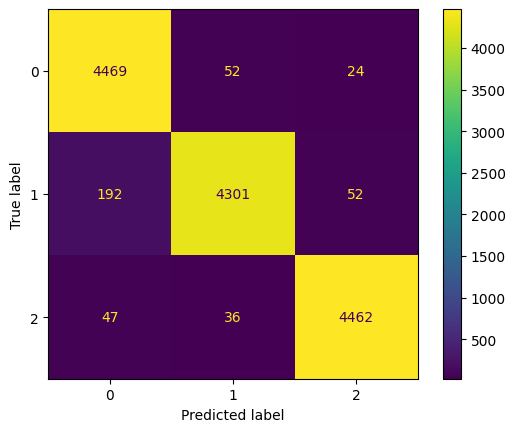

*** validation_matched ***


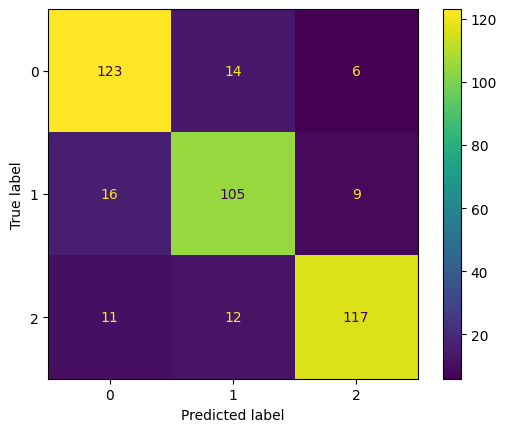

*** validation_mismatched ***


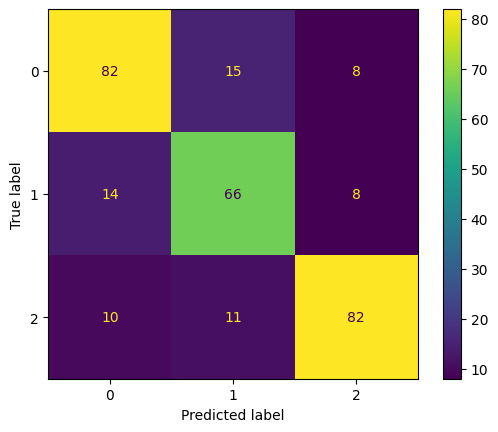

In [11]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print(f"*** {subset} ***")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [12]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

metrics = {}
for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    pre = precision_score(y_true=y_true, y_pred=y_pred, average=None)
    rec = recall_score(y_true=y_true, y_pred=y_pred, average=None)
    metrics[subset] = [acc] + pre.tolist() + rec.tolist()
    print(f"Subset: {subset}:")
    print(f"Accuracy: {acc:.2f} | Precision0: {pre[0]:.2f} | Precision1: {pre[1]:.2f} | Precision2: {pre[2]:.2f} | Recall0: {rec[0]:.2f} | Recall1: {rec[1]:.2f} | Recall2: {rec[2]:.2f}")
    print("-----\n")

Subset: train:
Accuracy: 0.97 | Precision0: 0.95 | Precision1: 0.98 | Precision2: 0.98 | Recall0: 0.98 | Recall1: 0.95 | Recall2: 0.98
-----

Subset: validation_matched:
Accuracy: 0.84 | Precision0: 0.82 | Precision1: 0.80 | Precision2: 0.89 | Recall0: 0.86 | Recall1: 0.81 | Recall2: 0.84
-----

Subset: validation_mismatched:
Accuracy: 0.78 | Precision0: 0.77 | Precision1: 0.72 | Precision2: 0.84 | Recall0: 0.78 | Recall1: 0.75 | Recall2: 0.80
-----



### Criterio de evaluación

La **nota final de la tarea1** estará relacionada con el resultado de las métricas de vuestro modelo en la combinación de *accuracy*, *precision* y *recall* para cada _split_ de datos. 

El criterio de evaluación será el siguiente:
- La tarea1 se aprobará si el notebook se entrega sin fallos y con un modelo entrenado (independientemente de sus métricas). 
- La tarea1 tiene un 10 si se cumple que las métricas de vuestro modelo entrenado igualan o superan los siguientes umbrales:

| Subset               | Accuracy | Precision0 | Precision1 | Precision2 | Recall0 | Recall1 | Recall2 |
|----------------------|----------|------------|------------|------------|---------|---------|---------|
| validation_matched    | 0.78     | 0.78       | 0.76       | 0.85       | 0.80    | 0.77    | 0.81    |
| validation_mismatched | 0.79     | 0.70       | 0.70       | 0.70       | 0.65    | 0.71    | 0.85    |

- Por cada valor inferior a dicha métrica, la tarea pierde 0.5 puntos (máximo 5.0 puntos de pérdida).

Nota: La nota que se calcula a continuación es orientativa y podría verse reducida en función del código de la entrega. 

In [13]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def calculo_nota(metric):

    vm_acc = float(metric['validation_matched'][0])
    vm_pre0 = float(metric['validation_matched'][1])
    vm_pre1 = float(metric['validation_matched'][2])
    vm_pre2 = float(metric['validation_matched'][3])
    vm_rec0 = float(metric['validation_matched'][4])
    vm_rec1 = float(metric['validation_matched'][5])
    vm_rec2 = float(metric['validation_matched'][6])
    vmm_acc = float(metric['validation_mismatched'][0])
    vmm_pre0 = float(metric['validation_mismatched'][1])
    vmm_pre1 = float(metric['validation_mismatched'][2])
    vmm_pre2 = float(metric['validation_mismatched'][3])
    vmm_rec0 = float(metric['validation_mismatched'][4])
    vmm_rec1 = float(metric['validation_mismatched'][5])
    vmm_rec2 = float(metric['validation_mismatched'][6])

    thresholds = {
        'vm_acc': 0.78, 'vm_pre0': 0.78, 'vm_pre1': 0.76, 'vm_pre2': 0.85,
        'vm_rec0': 0.80, 'vm_rec1': 0.77, 'vm_rec2': 0.81,
        'vmm_acc': 0.79, 'vmm_pre0': 0.70, 'vmm_pre1': 0.70, 'vmm_pre2': 0.70,
        'vmm_rec0': 0.65, 'vmm_rec1': 0.71, 'vmm_rec2': 0.85,
    }
    values = {
        'vm_acc': vm_acc, 'vm_pre0': vm_pre0, 'vm_pre1': vm_pre1, 'vm_pre2': vm_pre2,
        'vm_rec0': vm_rec0, 'vm_rec1': vm_rec1, 'vm_rec2': vm_rec2,
        'vmm_acc': vmm_acc, 'vmm_pre0': vmm_pre0, 'vmm_pre1': vmm_pre1, 'vmm_pre2': vmm_pre2,
        'vmm_rec0': vmm_rec0, 'vmm_rec1': vmm_rec1, 'vmm_rec2': vmm_rec2,
    }

    nota = 10
    for key in thresholds:
        if values[key] < thresholds[key]:
            nota -= 0.5
    return max(nota, 5.0)

print(f"Tu nota de la tarea1 es: {calculo_nota(metrics)}")

Tu nota de la tarea1 es: 9.0
